# NN ensemble classifier


## Import

### Import modules

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
import timeit #more accurate than time

import theano

from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import binned_statistic_2d

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.layers import Dense, Activation
from keras.models import Sequential, model_from_json, load_model

import seaborn as sns
sns.set_style("white")
import os
import json

from six.moves import cPickle #Faster than pickle

import sys
sys.path.append('../modules/')
from MPPlot import *
from Processors import *

Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


### Choose backend

In [2]:
import importlib

def set_keras_backend(backend):
    """
    Changes Keras backend
    
    Parameters
    ----------
    backend : str
              Backend wanted (theano or tensorflow)
              
    Returns
    -------
    """
    
    idm = {"theano": "th", "tensorflow": "tf"}
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
        keras.backend.set_image_dim_ordering(idm[backend])

set_keras_backend("theano")

## Import dataTrain

In [3]:
loc = "../data/"
dataTrain = pandas.read_csv(loc + "DS_1_train.csv")
sigdataTrain = dataTrain.signal == 1.0
bkgdataTrain = dataTrain.signal == 0.0
print("Samples contains {} signal events and {} background events, {} events total".format(
        len(dataTrain[sigdataTrain]), len(dataTrain[bkgdataTrain]), len(dataTrain)))

Samples contains 51018 signal events and 1072159 background events, 1123177 events total


In [4]:
dataTrain.head()

,index,event_id,X,Y,Z,TX,TY,chi2,signal
0,0,-999,42720.238281,75152.406250,32325.0,-0.475539,0.405506,2.652586,0.0
1,1,-999,46023.816406,37043.359375,21981.0,0.330822,-0.013988,2.497527,0.0
2,2,-999,52706.117188,33872.730469,16809.0,0.342634,-0.058724,2.120421,0.0
3,3,-999,47334.101562,9698.531250,60771.0,0.007868,-0.632822,0.618535,0.0
4,4,-999,67380.835938,19137.265625,37497.0,-0.212537,-0.192243,2.799303,0.0


### Process dataTrain and add new features

In [3]:
name = "weights/NN_Regressor_2"
regInputPipe = None
regOutputPipe = None
compileArgs = None
with open(name + '_compile.pkl', 'r') as fin:
    compileArgs = json.load(fin)
regressor = model_from_json(open(name + '.json').read())
regressor.load_weights(name + '.h5')
regressor.compile(**compileArgs)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    regInputPipe = cPickle.load(fin)
with open(name + '_outputPipe.pkl', 'rb') as fin:
    regOutputPipe = cPickle.load(fin)

In [4]:
regTrainFeatures = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']

In [7]:
dataTrain['reg_P'] = regOutputPipe.inverse_transform(regressor.predict(
        regInputPipe.transform(dataTrain[regTrainFeatures].values.astype('float32')), verbose=0))

### Create development and validation samples
Development dataTrain is used for training and testing. Validation is used for testing the final classifier.

This defines lists of indices for signal and background events for the development and validation samples. About 20% of each class is reserved for validation

In [8]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in dataTrain[sigdataTrain].index.tolist()],
                                 test_size=0.05, random_state=2592)
bkg_devIndeces, bkg_valIndeces = \
                train_test_split([i for i in dataTrain[bkgdataTrain].index.tolist()],
                                 test_size=0.05, random_state=2592)

Here we split the full dataTrainset into the dev and val sets, and define aliases for the cuts necessary to select signal and background events in each.

In [9]:
devdataTrain = dataTrain.loc[sig_devIndeces].copy()
devdataTrain = devdataTrain.append(dataTrain.loc[bkg_devIndeces].copy(), ignore_index = True)
valdataTrain = dataTrain.loc[sig_valIndeces].copy()
valdataTrain = valdataTrain.append(dataTrain.loc[bkg_valIndeces].copy(), ignore_index = True)

sigDev = (devdataTrain.signal == 1.0)
bkgDev = (devdataTrain.signal == 0.0)
sigVal = (valdataTrain.signal == 1.0)
bkgVal = (valdataTrain.signal == 0.0)

print("{} events for training, {} events for validation".format(len(devdataTrain), len(valdataTrain)))
print("Dev: {} of which are signal and {} are background".format(len(devdataTrain[sigDev]), len(devdataTrain[bkgDev])))
print("Val: {} of which are signal and {} are background".format(len(valdataTrain[sigVal]), len(valdataTrain[bkgVal])))

1067018 events for training, 56159 events for validation
Dev: 48467 of which are signal and 1018551 are background
Val: 2551 of which are signal and 53608 are background


Since there are more background events, let's define weights to help balance out the classes.

In [10]:
classWeights = {0.0 : 1.0,
                1.0 : len(devdataTrain[bkgDev])/len(devdataTrain[sigDev])}
print("Dev Weights are: ", classWeights)

Dev Weights are:  {0.0: 1.0, 1.0: 21.015350650958386}


## XY weights

In [11]:
signalXY = binned_statistic_2d(devdataTrain.ix[sigDev, 'X'].values,
                                  devdataTrain.ix[sigDev, 'Y'].values,
                                  devdataTrain.ix[sigDev, 'Y'].values,
                                  statistic='count', expand_binnumbers=True,
                                  range=((np.min(devdataTrain.ix[sigDev, 'X'].values),
                                          np.max(devdataTrain.ix[sigDev, 'X'].values)),
                                         (np.min(devdataTrain.ix[sigDev, 'Y'].values),
                                          np.max(devdataTrain.ix[sigDev, 'Y'].values))),
                                  bins=(50, 50))

In [12]:
devdataTrain.ix[sigDev, 'weight'] = 1/signalXY.statistic[signalXY.binnumber[0]-1, signalXY.binnumber[1]-1]
devdataTrain.ix[sigDev, 'weight'] = devdataTrain.ix[sigDev, 'weight']/np.sum(devdataTrain.ix[sigDev, 'weight'])
devdataTrain.ix[bkgDev, 'weight'] = 1/len(devdataTrain[bkgDev])

## Options
Define the features used for discrimination and training options

### Feature sets

In [5]:
trainFeatures = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2', 'reg_P']

In [6]:
set0 = ['X', 'Y', 'Z', 'TX', 'TY', 'chi2']
set1 = trainFeatures

### Training options
Here we define the way we'll train the classifier. For simplicity we'll just use the low-level final-state features. We can also choose what pre-processing step to apply to the dataTrain.

In [7]:
classTrainFeatures = set1 #The features used
classModel = "model0" #Will define the layout of the network
varSet = "set1" #Name of the feature set used, mainly for saving results
normIn = True #Whether we want to normalise and standardise the inputs
pca = True #Whether we want to use principal-component analysis to decorrelate inputs
whiten = False #Whether we want to whiten input dataTrain
normPCA = True #Whether we want to normalise and standardise the inputs after PCA
nSplits = 10 #Number of train/test splits to make during cross-validation
ensembleSize = 10 #Number of classifiers  to include in ensemble = min(nSplits, ensembleSize)
ensembleMode = 'AUC' #Metric used to weight classifiers in ensemble, I've found loss to quite relaible
compileArgs = {'loss':'binary_crossentropy', 
               'optimizer':'nadam'} #Loss function and optimiser for NN
trainParams = {'epochs' : 10000, 
               'batch_size' : 64, 
               'verbose' : 0} #Maximum epochs for training and size of mini-batch
print("Training on {} features {}". format(len(classTrainFeatures),[var for var in classTrainFeatures]))

Training on 7 features ['X', 'Y', 'Z', 'TX', 'TY', 'chi2', 'reg_P']


## Pre-process dataTrain

Here we define a SK-Learn pipeline which will contain transformation steps for any dataTrain fed in. Pipelines are a nice, compact way of handing dataTrain transformations.

In [16]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
        if normPCA:
            stepsIn.append(('normPCA', StandardScaler()))
inputPipe = Pipeline(stepsIn)
stepsOut = []

Next we fit the pipeline to the **development** dataTrain inputs. For compactness we also transform the development dataTrain and create Numpy arrays of the inputs and targets. **N.B.** The type of the inputs will normally be either float32 or float64. float32 is preferred, since speed and memory outweighs precision. Sometimes if the dataTrain is naturally in float64, the conversion to float32 can can result in NaNs or infs, so watch out.

In [17]:
inputPipe.fit(devdataTrain[sigDev][classTrainFeatures].values.astype('float32')) #Fit to signal
X_class = inputPipe.transform(devdataTrain[classTrainFeatures].values.astype('float32'))
y_class = devdataTrain['signal'].values.astype('int') #Outputs
X_weights = devdataTrain['weight'].values.astype('float64') #Weights

## Define classifier
Here we define the layout of the neural network. The basic class is sequential. The network is them defined by adding dense layers (which contain the neurons and weights) and then the activation function. The activation function can be defined directly in the dense constructor, however adding separately gives a clearer picture of the network, and allows it to be easily replaced with an advanced activation-function.

For contempory ML, the rectified linear unit is generally the default activation function. Since we want the outputs to be between 0 (background) and 1 (signal) we'll use the sigmoid function as the final activation function, since it saturates at these values and is symmetric between them.

The compile step combines the choice of loss function and optimiser into the model.

In [18]:
from theano import tensor as T

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*T.nnet.elu(x, alpha)

In [19]:
def getClassifier(model, nIn, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    if model == "model0":
        depth = 3
        width = 100
        classModel.add(Dense(width, input_dim=nIn, kernel_initializer='he_normal')) #First layer requires number of inputs
        classModel.add(Activation('relu')) #Add ReLU activation function
        for i in range(depth): #Continue to add hidden layers
            classModel.add(Dense(width, kernel_initializer='he_normal')) #Subsequent layers inherit input_dim from previous layer
            classModel.add(Activation('relu'))
    if model == "model1":
        depth = 3
        width = 100
        classModel.add(Dense(width, input_dim=nIn, kernel_initializer='he_normal')) #First layer requires number of inputs
        classModel.add(Activation(selu)) #Add ReLU activation function
        for i in range(depth): #Continue to add hidden layers
            classModel.add(Dense(width, kernel_initializer='he_normal')) #Subsequent layers inherit input_dim from previous layer
            classModel.add(Activation(selu))
    if model == "model3":
        depth = 5
        width = 100
        classModel.add(Dense(width, input_dim=nIn, kernel_initializer='he_normal')) #First layer requires number of inputs
        classModel.add(Activation(selu)) #Add ReLU activation function
        for i in range(depth): #Continue to add hidden layers
            classModel.add(Dense(width, kernel_initializer='he_normal')) #Subsequent layers inherit input_dim from previous layer
            classModel.add(Activation(selu))
    classModel.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')) #Final layer requires one output
    classModel.compile(**compileArgs) #Compile the network graph to prepare it for use
    return classModel

### Callbacks

Callbacks are methods that can be called during training. They have a variety of uses such as monitoring training, stopping training early, and saving different versions of the model. Here we define our own callback,  which saves the history of the training.

We want to view the history of the model's performance on the training and testing dataTrain during dataTrain, however by default the training loss is averaged over the epoch, and the test loss is evaluated at the end of the epoch, so is not comparable. This modified version evaluates the performance on the training dataTrain at the end of each epoch.

Later well also use some other callbacks:

EarlyStopping monitors a specified metric and stops the training if the performance fails to improve for a specified number of epochs in a row. Here we use it to monitor the loss on the test dataTrain and stop when it doesn't improve after 10 epochs.

ModelCheckpoint is used to save the weights of the network during training. It's quite flexible, but here we use it save the model which performs best according to the loss in test dataTrain.

Normally during training, the test loss will reach a minimum and either saturate or start to increase (overtraining). The training loss will normally either saturate or continue to decrease. The optimum point is when the test-loss first reaches its minimum point. The combination of EarlyStopping and ModelCheckpoint acts to save the model at this point and allow some leeway in case it starts to decrease again.

In [20]:
class LossHistory(Callback):
    def __init__(self, trdataTrain):
        self.trainingdataTrain = trdataTrain
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingdataTrain[0], self.trainingdataTrain[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

## Train classifier

Now we're ready to train the classifier.

We use stratified k-fold cross-validation for training. This splits the full development dataTrain into *k* sets, trains the model on $k-1$ sets and tests its performance on the remainings set. This then continues *k* times with a different set being used for testing each time. The *stratified* part means that each set will contain the same fraction of event classes as the full dataTrainset, which helps ensure unbiased training and means that our class weights will be valid.

During training we save each trained model, as well as its performance on the test set.

**N.B.** The model can either be saved directly, or by saving the weights and layout separately. The former is more compact, but doesn't handle custom objects well. If you've used a custom loss or activation function, the the second method is more flexible. It also seems to be quicker, but I've not done concrete tests...

In [22]:
start = timeit.default_timer()

results = []
histories = []

os.system("mkdir train_weights")
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")

skf = StratifiedKFold(n_splits=nSplits, shuffle=True)

i = 0
for train, test in skf.split(X_class, y_class): #test and train are sets of indices for the current CV fold
    i += 1
    print("Running fold", i, "/", nSplits)
    
    foldStart = timeit.default_timer()
    
    model = None # Clearing the NN
    model = getClassifier(classModel, len(classTrainFeatures), compileArgs)
    model.reset_states #Just checking
    
    lossHistory = LossHistory((X_class[train], y_class[train]))
    earlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
                               save_best_only=True, save_weights_only=True, mode='auto', period=1)
    
    #Begin training the model
    model.fit(X_class[train], y_class[train], validation_data = (X_class[test], y_class[test]),
              callbacks = [earlyStop, saveBest, lossHistory],
              class_weight=classWeights,
              sample_weight=X_weights[train], **trainParams)
    
    histories.append(lossHistory.losses) #Saves the loss history from callback
    model.load_weights("train_weights/best.h5") #Loads the best model saved by ModelCheckpoint
    
    results.append({})
    results[-1]['loss'] = model.evaluate(X_class[test], y_class[test], verbose=0) #Gets loss on test dataTrain
    results[-1]['AUC'] = 1-roc_auc_score(y_class[test], model.predict(X_class[test], verbose=0)) #Gets ROC AUC for test dataTrain
    
    print("Score is:", results[-1])
    print("Fold took {:.3f}s ".format(timeit.default_timer() - foldStart))
    
    model.save('train_weights/train_' + str(i-1) + '.h5') #Save the model

with open('train_weights/resultsFile.pkl', 'wb') as fout: #Save results
    cPickle.dump(results, fout)

print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))

X_class = None
y_class = None
train = None
test = None
model.summary() #Prints a summary of the model layout
model = None

Running fold 1 / 10
Epoch 00020: early stopping
Score is: {'loss': 0.25350321201099796, 'AUC': 0.041267772433706718}
Fold took 717.353s 
Running fold 2 / 10
Epoch 00029: early stopping
Score is: {'loss': 0.24610662060195876, 'AUC': 0.040659219993972706}
Fold took 1011.436s 
Running fold 3 / 10
Epoch 00033: early stopping
Score is: {'loss': 0.23182517400538294, 'AUC': 0.040914694476467117}
Fold took 1152.722s 
Running fold 4 / 10
Epoch 00017: early stopping
Score is: {'loss': 0.24924510396387589, 'AUC': 0.040792973648091424}
Fold took 674.997s 
Running fold 5 / 10
Epoch 00011: early stopping
Score is: {'loss': 0.26745088151663338, 'AUC': 0.058086975970616184}
Fold took 400.194s 
Running fold 6 / 10
Epoch 00061: early stopping
Score is: {'loss': 0.2424253876412682, 'AUC': 0.041860562083967601}
Fold took 2222.343s 
Running fold 7 / 10
Epoch 00015: early stopping
Score is: {'loss': 0.25118081300779843, 'AUC': 0.042893411191856745}
Fold took 582.108s 
Running fold 8 / 10
Epoch 00022: early 

### Plot histories
Now let's plot the history of the training.

We can see that the test loss starts to decrease, reaches a minimum point, then begins to increase. The training loss continues to decrease. The early stopping detects the lack of imporvement in test loss and stops the training. The checkpoint allows us to use the state of the model at the minimum point of training loss.

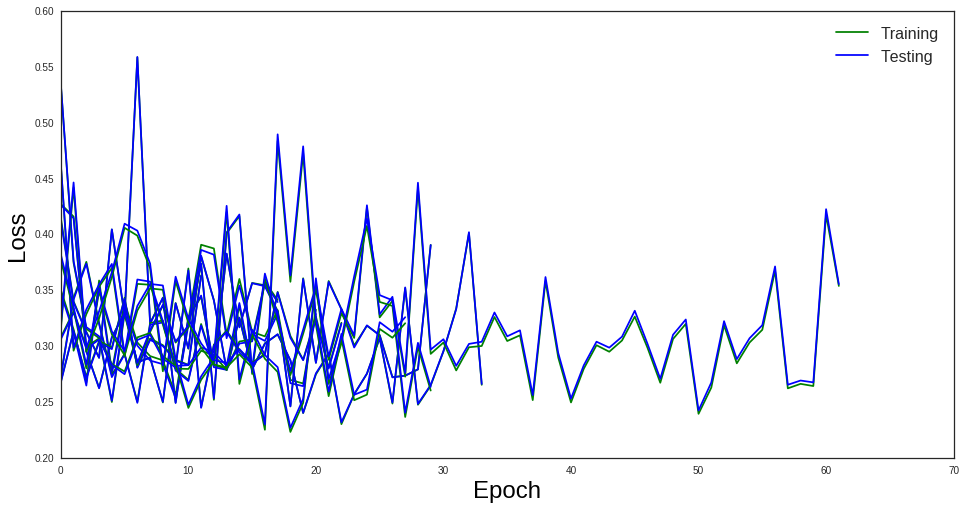

In [25]:
plt.figure(figsize=(16,8))

for i, history in enumerate(histories):
    if i == 0:
        plt.plot(history['loss'], color='g', label='Training')
        plt.plot(history['val_loss'], color='b', label='Testing')
    else:
        plt.plot(history['loss'], color='g')
        plt.plot(history['val_loss'], color='b')
        
plt.legend(fontsize=16)
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("Loss", fontsize=24, color='black')
#plt.ylim((0.0, 0.2))
plt.show()

## Ensemble Size

### Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

In [26]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

In [27]:
def loadModel(cycle, location='train_weights/train_'): #Function to load a specified classifier
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [28]:
def getWeights(value, met): #How the weight is calculated. Metrics configured such that lower values are better.
    return 1/value #Reciprocal of metric is a simple way of assigning larger weight s to better metrics

Now we order the classifiers by performance, load the required number, and weight them

In [29]:
ensemble = []
weights = []

print("Choosing ensemble by", ensembleMode)
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], 
                          dtype=dtype), order=['result'])

for i in range(min([ensembleSize, len(results)])):
    ensemble.append(loadModel(values[i]['cycle']))
    weights.append(getWeights(values[i]['result'], ensembleMode))
    print("Model {} is {} with {} = {}". format(i, values[i]['cycle'], ensembleMode, values[i]['result']))
    
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by AUC
Model 0 is 1 with AUC = 0.040659219994
Model 1 is 8 with AUC = 0.0407279032956
Model 2 is 3 with AUC = 0.0407929736481
Model 3 is 2 with AUC = 0.0409146944765
Model 4 is 0 with AUC = 0.0412677724337
Model 5 is 5 with AUC = 0.041860562084
Model 6 is 7 with AUC = 0.0419832586332
Model 7 is 9 with AUC = 0.0424573329006
Model 8 is 6 with AUC = 0.0428934111919
Model 9 is 4 with AUC = 0.0580869759706


### Response on dev dataTrain

Now let's apply the ensemble to the whole of the development dataTrain

#### Pre-process dataTrain

In [30]:
X_dev = inputPipe.transform(devdataTrain[classTrainFeatures].values.astype('float32'))

#### Get response

In [8]:
def predict(indataTrain, ensemble, weights, n=-1): #Loop though each classifier and predict dataTrain class
    pred = np.zeros((len(indataTrain), 1))
    if n == -1:
        n = len(ensemble)+1
    ensemble = ensemble[0:n] #Use only specified number of classifiers
    weights = weights[0:n]
    weights = weights/weights.sum() #Renormalise weights
    
    for i, model in enumerate(ensemble):
        pred += weights[i] * model.predict(indataTrain, verbose=0)
        
    return pred

In [32]:
pred = predict(X_dev, ensemble, weights)
devdataTrain['pred_class'] = pandas.Series(pred[:,0], index=devdataTrain.index) #Add predicted class to dataTrain

In [33]:
devAUC = roc_auc_score(devdataTrain["signal"].values.astype('int'), devdataTrain['pred_class'])
print('Area under ROC curve for development dataTrain is {:.5f}'.format(devAUC))

Area under ROC curve for development dataTrain is 0.96297


#### Ensemble testing
What benefit does ensembling bring? Let's take a look!

In [ ]:
for i in range(ensembleSize):
    auc = roc_auc_score(devdataTrain["signal"].values.astype('int'),
                        predict(X_dev, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

Definite improvements seen, but the improvements will eventually saturate. The number to use and the ways the weights are calculated are hyperparameters of the MVA. We could have set aside some of the development dataTrain for tuning this, but for now we'll just stick with what we have.

### Response on val dataTrain
Having done all the development of the classifier, we're now ready to do final testing on the withheld validation dataTrain.

#### Pre-process dataTrain

In [34]:
X_val = inputPipe.transform(valdataTrain[classTrainFeatures].values.astype('float32'))

#### Get response

In [35]:
pred = predict(X_val, ensemble, weights)
valdataTrain['pred_class'] = pandas.Series(pred[:,0], index=valdataTrain.index) #Add predicted class to dataTrain

In [36]:
valAUC = roc_auc_score(valdataTrain["signal"].values.astype('int'), valdataTrain['pred_class'])
print('Area under ROC curve for validation dataTrain is {:.5f}'.format(valAUC))

Area under ROC curve for validation dataTrain is 0.96259


#### Ensemble testing
Again we can confirm that ensembling helps. **N.B.** Do not use the validation dataTrain for any tuning!

In [37]:
for i in range(ensembleSize):
    auc = roc_auc_score(valdataTrain["signal"].values.astype('int'),
                              predict(X_val, ensemble, weights, i+1))
    if not i:
        print("AUC using best classifier:\t{:.5f}".format(auc))
    else:
        print("AUC using {} classifiers:\t{:.5f}".format(i+1, auc))

AUC using best classifier:	0.95852
AUC using 2 classifiers:	0.96155
AUC using 3 classifiers:	0.96184
AUC using 4 classifiers:	0.96279
AUC using 5 classifiers:	0.96284
AUC using 6 classifiers:	0.96336
AUC using 7 classifiers:	0.96320
AUC using 8 classifiers:	0.96323
AUC using 9 classifiers:	0.96308
AUC using 10 classifiers:	0.96259


## Construct ensemble
During the *k*-fold CV we trained *k* models. We could just use the best one, however it is unlikely to optimimum for all input possibilities. Ensembling is a method of using multiple classifiers together to achieve a better result than a single one on its own.

The method I use here is to weight the contributions of each classifier according to how well it performed on its test set during CV.

In [48]:
ensembleSize = 6

In [49]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin: #Reload results in case notebook was closed
    results = cPickle.load(fin)

Now we order the classifiers by performance, load the required number, and weight them

In [50]:
ensemble = []
weights = []

print("Choosing ensemble by", ensembleMode)
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], 
                          dtype=dtype), order=['result'])

for i in range(min([ensembleSize, len(results)])):
    ensemble.append(loadModel(values[i]['cycle']))
    weights.append(getWeights(values[i]['result'], ensembleMode))
    print("Model {} is {} with {} = {}". format(i, values[i]['cycle'], ensembleMode, values[i]['result']))
    
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by AUC
Model 0 is 1 with AUC = 0.040659219994
Model 1 is 8 with AUC = 0.0407279032956
Model 2 is 3 with AUC = 0.0407929736481
Model 3 is 2 with AUC = 0.0409146944765
Model 4 is 0 with AUC = 0.0412677724337
Model 5 is 5 with AUC = 0.041860562084


## Response on dev dataTrain

Now let's apply the ensemble to the whole of the development dataTrain

### Pre-process dataTrain

In [51]:
X_dev = inputPipe.transform(devdataTrain[classTrainFeatures].values.astype('float32'))

### Get response

In [52]:
pred = predict(X_dev, ensemble, weights)
devdataTrain['pred_class'] = pandas.Series(pred[:,0], index=devdataTrain.index) #Add predicted class to dataTrain

In [53]:
devAUC = roc_auc_score(devdataTrain["signal"].values.astype('int'), devdataTrain['pred_class'])
print('Area under ROC curve for development dataTrain is {:.5f}'.format(devAUC))

Area under ROC curve for development dataTrain is 0.96381


## Response on val dataTrain
Having done all the development of the classifier, we're now ready to do final testing on the withheld validation dataTrain.

### Pre-process dataTrain

In [54]:
X_val = inputPipe.transform(valdataTrain[classTrainFeatures].values.astype('float32'))

### Get response

In [55]:
pred = predict(X_val, ensemble, weights)
valdataTrain['pred_class'] = pandas.Series(pred[:,0], index=valdataTrain.index) #Add predicted class to dataTrain

In [56]:
valAUC = roc_auc_score(valdataTrain["signal"].values.astype('int'), valdataTrain['pred_class'])
print('Area under ROC curve for validation dataTrain is {:.5f}'.format(valAUC))

Area under ROC curve for validation dataTrain is 0.96336


## Evaluation

### ROC curve
In the earlier evaluations of the ROC AUC we took the dataTrain altogether giving one evaluation of the ROC and no uncertainty. Instead we can sample the predictions with replacement and evaluate the ROC on the bootstrap samples. By doing this many times we can converge to a better estimation of true ROC AUC, and get an uncertainty.

This takes a while so we'll use multithreading to evaluate both development and validation performance at once.

In [ ]:
aucArgs = [{'labels':valdataTrain['signal'], 'preds':valdataTrain['pred_class'], 
            'name':'Val', 'indeces':valdataTrain.index.tolist()},
           {'labels':devdataTrain['signal'], 'preds':devdataTrain['pred_class'], 
            'name':'Dev', 'indeces':devdataTrain.index.tolist()}]
aucs = mpRun(aucArgs, rocauc)

In [ ]:
meanScores = {}

for sample in ['Dev', 'Val']:
    meanScores[sample] = (np.mean(aucs[sample]), np.std(aucs[sample])/np.sqrt(len(aucs[sample])))
    print(sample + ' ROC AUC, Mean = {} +- {}'.format(meanScores[sample][0], meanScores[sample][1]))

In [ ]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(devdataTrain['signal'].values, devdataTrain['pred_class'].values)[:2],
         label=r'Dev, $auc={:.5f}\pm{:.5f}$'.format(meanScores['Dev'][0], meanScores['Dev'][1]),
         linestyle='dashed', color='b')
plt.plot(*roc_curve(valdataTrain['signal'].values, valdataTrain['pred_class'].values)[:2],
         label=r'Val, $auc={:.5f}\pm{:.5f}$'.format(meanScores['Val'][0], meanScores['Val'][1]),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### MVA distribution
We can also plot the distribution of the predicted class

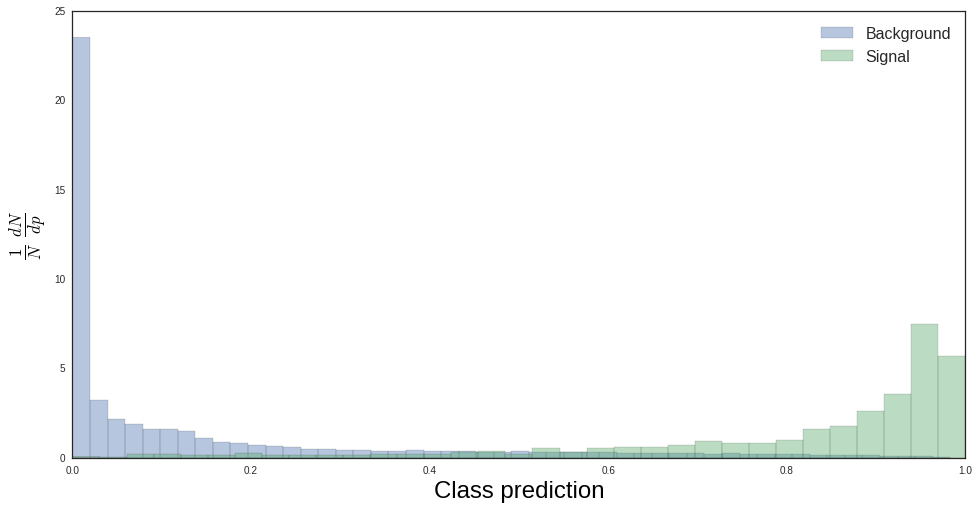

In [57]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True}
plt.figure(figsize=(16, 8))
sns.distplot(valdataTrain[bkgVal]['pred_class'], label='Background', **params)
sns.distplot(valdataTrain[sigVal]['pred_class'], label='Signal', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
#plt.yscale('log', nonposy='clip')
plt.show()

## Application

In [58]:
loc = "../data/"
dataTest = pandas.read_csv(loc + "DS_1_test.csv")
print("Samples contains {} events total".format(len(dataTest)))

Samples contains 1126099 events total


### Pre-process dataTrain

In [59]:
dataTest['reg_P'] = regOutputPipe.inverse_transform(regressor.predict(
        regInputPipe.transform(dataTest[regTrainFeatures].values.astype('float32')), verbose=0))

In [60]:
X = inputPipe.transform(dataTest[classTrainFeatures].values.astype('float32'))

### Get response

In [61]:
pred = predict(X, ensemble, weights)
dataTest['Prediction'] = pandas.Series(pred[:,0], index=dataTest.index) #Add predicted class to dataTrain

### Save predictions

In [62]:
dataTest.index.name = 'Id'
dataTest.to_csv('NN_set1_model5.csv', header=True, columns=['Prediction'])

## Compare Train to Test

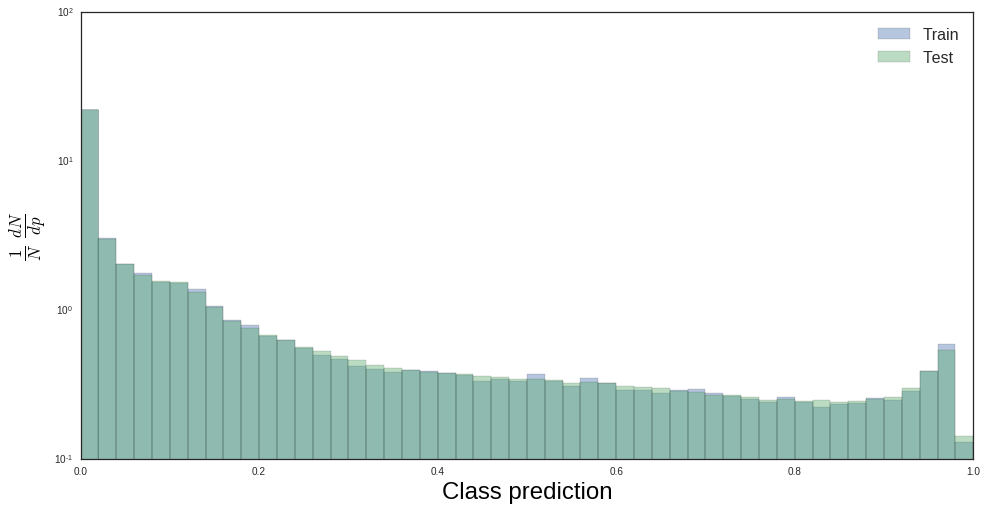

In [63]:
params = {'hist' : True, 'kde' : False, 'norm_hist' : True}
plt.figure(figsize=(16, 8))
sns.distplot(valdataTrain['pred_class'], label='Train', **params)
sns.distplot(dataTest['Prediction'], label='Test', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
plt.xlim([0,1])
plt.yscale('log', nonposy='clip')
plt.show()

## Save/load
We can save the classifier and load it later

In [9]:
name = "weights/NN_PreWeight_ClassWeight_{}_{}".format(varSet, classModel)
print(name)

weights/NN_PreWeight_ClassWeight_set1_model0


### Save

In [47]:
os.system("mkdir weights")
os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble): #This is the other way of saving Keras models
    json_string = model.to_json()
    open("{0}_{1}.json".format(name, i), 'wb').write(str.encode(json_string)) #Save layout as json
    model.save_weights(name + '_' + str(i) + '.h5') #Save weights as h5
with open(name + '_compile.pkl', 'w') as fout: #Save compile arguments; loaded model might need recompiling
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout: #Save weights for ensembling
    cPickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout: #Save the pre-processing pipeline
    cPickle.dump(inputPipe, fout)

### Load

In [10]:
ensemble = []
weights = None
inputPipe = None
compileArgs = None
with open(name + '_compile.pkl', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = cPickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = cPickle.load(fin)